<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit7/Unit7ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Curves: Concepts

What you'll do:

- Answer questions about what a GP is, and its relationship to GLMs and splines.
- Practice applying one of: polynomial modeling, b splines, or GPs
- You'll get a chance to read about and try to comprehend a more standard implementation of a GP.

Have fun!

**Task1**:

Why would you ever want to include a polynomial element in a model you built? What's the benefit of using polynomials to model?

Adding higher degree terms allows the model to switch directions. Rather than simply modeling an either all upward or all downward relationship, it can predict increasing at some points and decreasing at others.

**Task2**:

Why would you ever NOT want to include a polynomial element in a model you built?

Polynomials can be very sensitive to the data they are fit to. This means that they can overfit the data and not generalize well to new data. This is especially true if the degree of the polynomial is too high. If you give it a high degree polynomial and it looks like a lower degree one, a lower degree should be used.

**Task3**:

What's the point of using b splines?

B splines help to prevent the overfitting that can occur with polynomials. They do this by breaking the range of the data into smaller segments and fitting a polynomial to each segment. This allows the model to capture the general shape of the data without fitting to the noise. It allows the model to use the very precise fitting of the polynomial, but only to a small portion of the data, thereby preventing overfitting of the whole data set.

**Task4**:

Describe what a Gaussian Process is, in your own words. *Don't worry about being correct, just try to explain it to yourself*. I will not grade this question for accuracy.

A Gaussian Process is the logical extreme of a b spline. It is taking every single data point, and assigning it a polynomial that relates it to the output and every other input data point. The way I am understanding it is sort of as a neural network with 2 hidden layers where the hidden layers have infinite nodes.

**Task5**:

Refit a model to the howell data, using one of the following: polynomial model, b splines, or GPs.
Plot the posterior predictive check on a scatter plot

You only need to use one . Remember, the simpler the model is, the better (usually).

Hint: If you use a polynomial or bspline, try a disdributional model


In [1]:
import preliz as pz
import bambi as bmb
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [2]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [3]:
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')
weight = howell["weight"].values
height = howell["height"].values

In [5]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(height))
}

priors = {
    "hsgp(hour, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_howell = bmb.Model("weight ~ 0 + hsgp(height, m=10, c=1.5)", howell, family="negativebinomial", priors=priors)
idata_howell = model_howell.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, hsgp(height, m=10, c=1.5)_sigma, hsgp(height, m=10, c=1.5)_ell, hsgp(height, m=10, c=1.5)_weights_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
There were 646 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: height


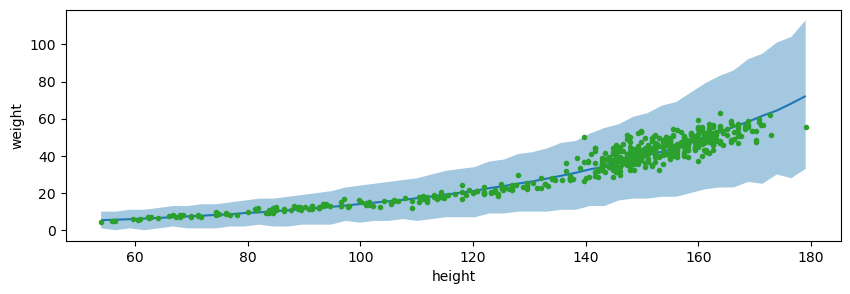

In [6]:
_, ax = bmb.interpret.plot_predictions(model_howell, idata_howell, ["height"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(height, weight, "C2.")

**Task6**:

Read the article on the pymc website about GP implementation on the Mauna Loa CO$_{2}$ data combined with CO$_{2}$ ice core data from the south pole.
[Link here.](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa2.html)

Write down one thing you learned about GPs from reading the article.

Note: You probably won't understand anything in this article. The main point of this task is to hammer home that good GP implementations are extremely technical.

What I learned is that real data scientists also just use functions from libraries -- the main difference being, they generally understand what those functions do. For instance, the model given at the very beginning of the article is legible to me. However, I most certainly don't have the knowledge to come up with one such model on my own. I don't know what a changepoint is, what the marginal likelihood means, or even really what a cov function is or how to select one. However, I know how to graph priors, how to put them together, and how to write a model in PyMC. So... progress?

**Task7**:

Describe your favorite graph from the article in the previous task. Explain why its your favorite.

The graph that I found most interesting was the second prediction graph. In the first one, at the end of the model, the predicted CO2 levels dipped back down towards zero. Immediately they went and fixed this by doing some weird stuff I don't understand and referencing a research paper, but made it end with a linear relationship continuing upward. I found this very cool, because it is precisely what I love about CS; you see something you don't like, and you can tell the computer to change it. I may not quite be at that point myself yet, but that seems to be the core of data science: try things, see what isn't quite right, and tweak them.